In [89]:
#### Import de libraries
import seaborn as sns
import math
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
import importlib
import functions 

In [90]:
X_train_reg = pd.read_csv('X_train_final.csv')
X_test_reg = pd.read_csv('X_test_final.csv')
X_oot_reg = pd.read_csv('X_oot_final.csv')

In [91]:
selected_vars=X_train_reg.columns.to_list()
selected_vars

['CRTOC_IND_0015_dis', 'CRTOC_IND_0164_dis', 'CRTOC_AG_NBJCRE_2T_IND_0009_dis', 'ratio_cred_ma_dis', 'CRTOC_AG_MVTAFF_2T_IND_0010_dis', 'CRTOC_MOY_MVTAFF_IND_0010_dis', 'CODETAJUR_I_dis', 'SECTNAF', 'DDefaut_NDB']

In [92]:
cible=selected_vars.pop(-1)

In [93]:
selected_vars

['CRTOC_IND_0015_dis', 'CRTOC_IND_0164_dis', 'CRTOC_AG_NBJCRE_2T_IND_0009_dis', 'ratio_cred_ma_dis', 'CRTOC_AG_MVTAFF_2T_IND_0010_dis', 'CRTOC_MOY_MVTAFF_IND_0010_dis', 'CODETAJUR_I_dis', 'SECTNAF']

# I. Construction du modèle

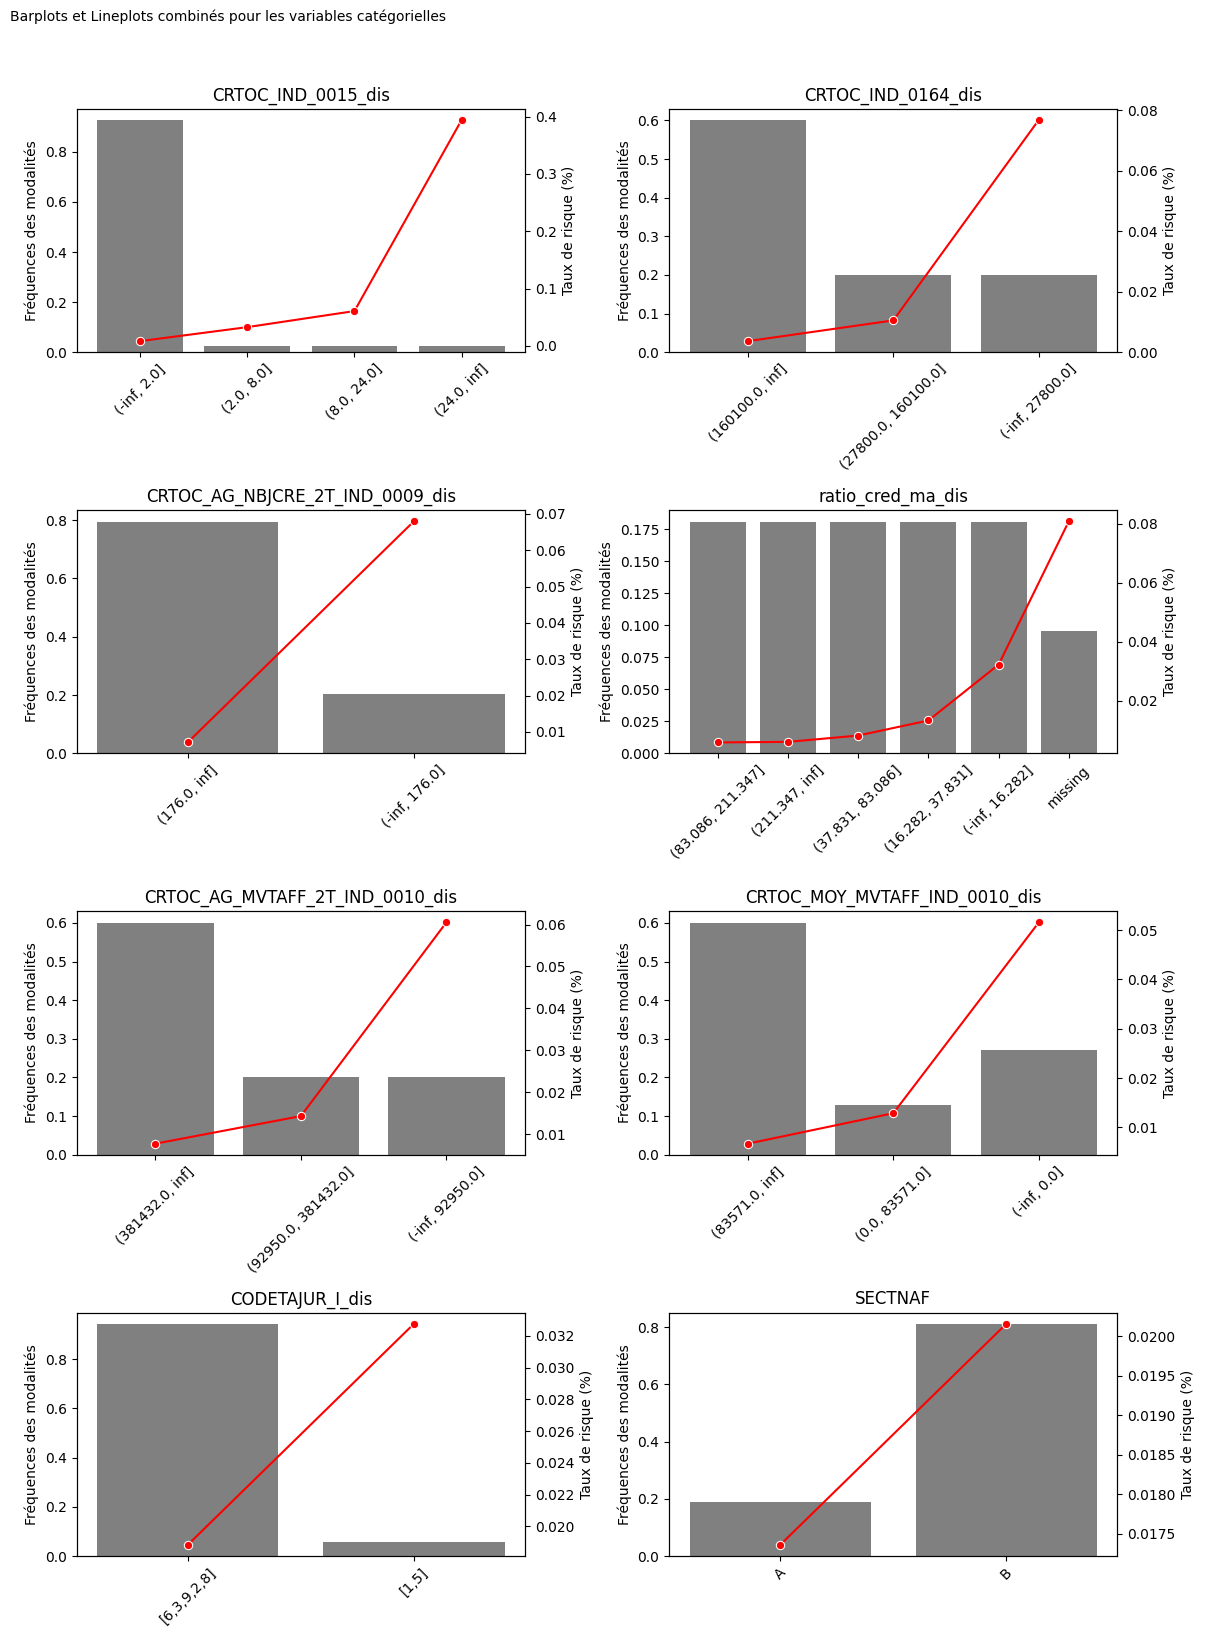

In [94]:
importlib.reload(functions)
functions.combined_barplot_lineplot(X_train_reg, selected_vars, cible)

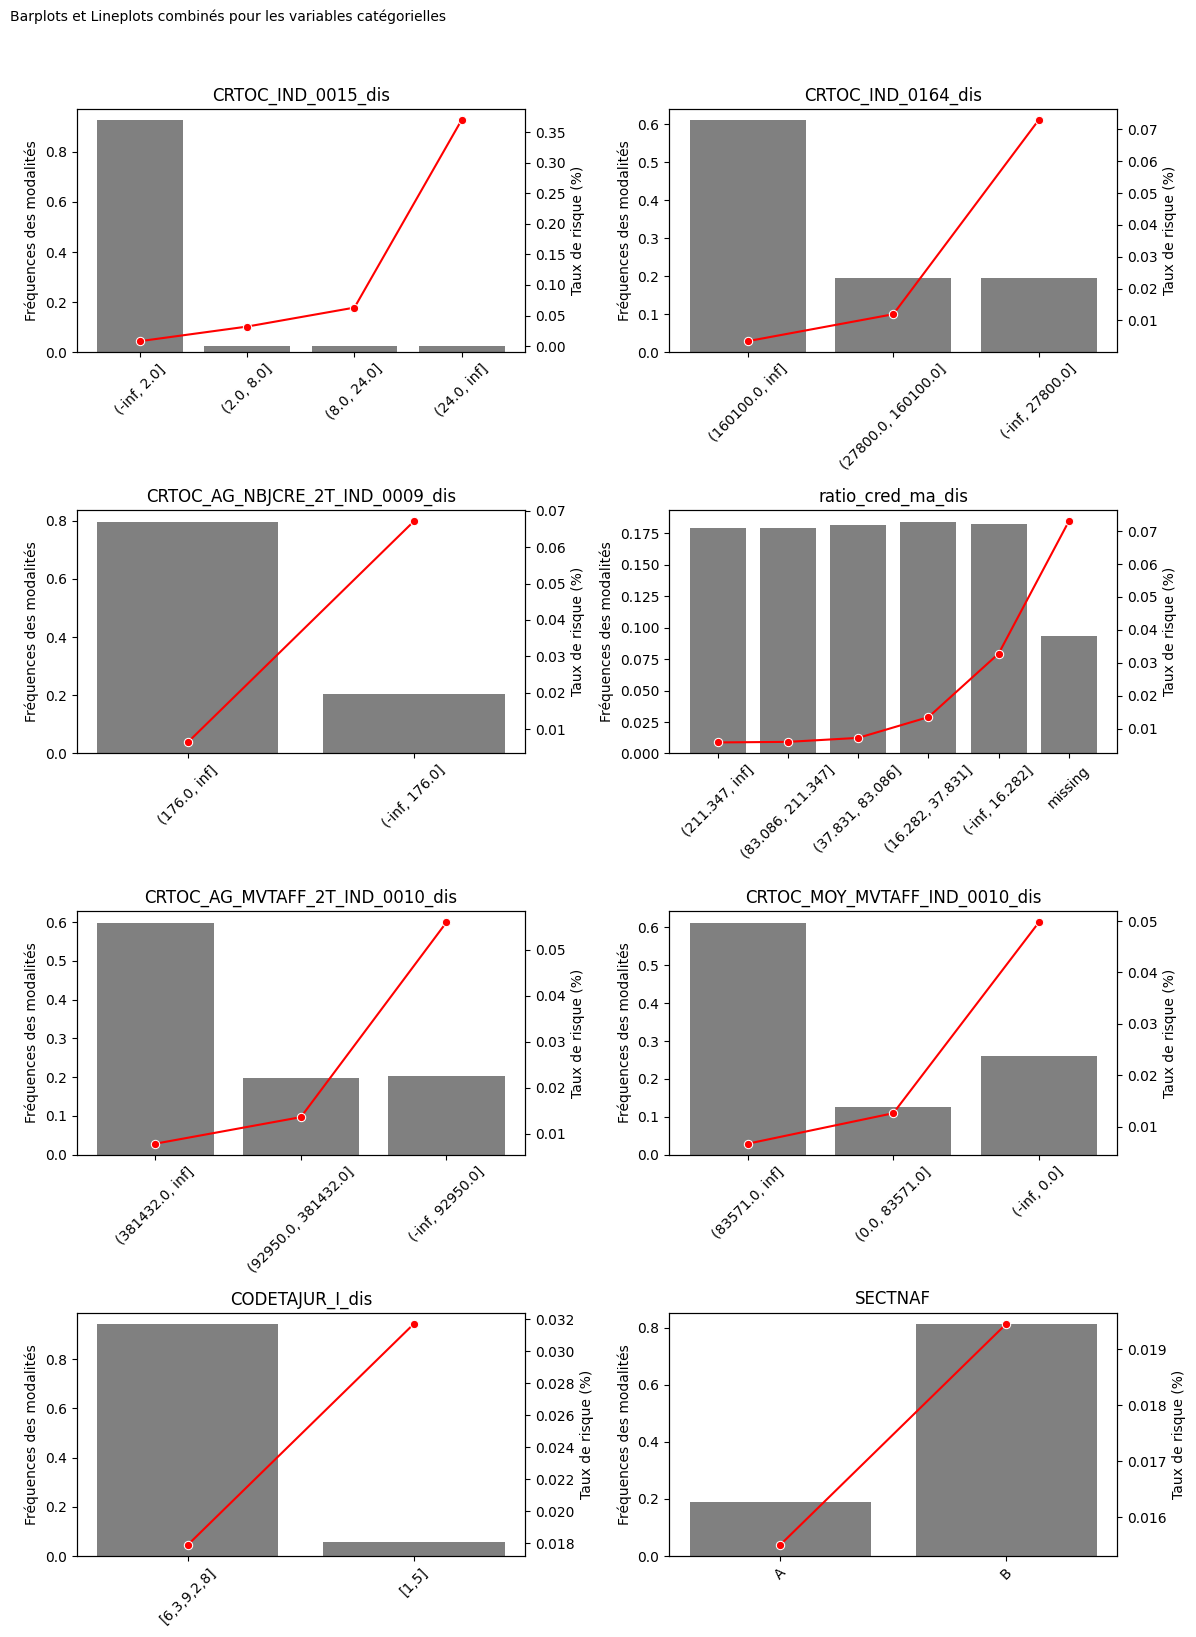

In [95]:
functions.combined_barplot_lineplot(X_oot_reg, selected_vars, cible)

## I. Démarche estimation du meilleur modèle logistique (1)

On vérifie pour chaque variable (et donc notamment à chaque fois qu’une variable est ajoutée dans les modèles itératifs, mais aussi au global dans les modèles
automatiques) que :
- Les coefficients de chaque modalité sont significatifs (5% en général, 10% accepté si nécessaire) ;
- La significativité globale des coefficients est ok (5%) ;
- Les coefficients sont croissants avec le risque de la modalité (par construction, la modalité 2 et moins risquée que la 3. Le coef de la modalité 3 doit donc etre
plus grand que celui de la 2) ;
- Les odds ratios sont significatifs entre chaque modalités d’une même variables (positifs et que leur IC ne contiennent pas 1).

In [96]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tqdm import tqdm

def logit_reg(cat_vars, cible, y, X_train_reg, modalites_reference=[]):
    # Préparer les données d'entraînement
    new_X_train = X_train_reg[cat_vars].copy()
    # Gestion des variables catégorielles
    if not modalites_reference:
        modalites_reference = []
        for var in cat_vars:
            freq_defaut = (
                X_train_reg.groupby(var, as_index=True)[cible]
                .mean()
                .reset_index()
                .sort_values(by=cible, ascending=True)
                .reset_index(drop=True)
            )
            modalites_reference.append(var + "_" + str(freq_defaut[var].iloc[0]))

    X_encoded = pd.get_dummies(new_X_train, columns=cat_vars).copy()

    # Supprimer les modalités de référence
    columns_to_drop = [col for col in modalites_reference if col in X_encoded.columns]
    X_encoded = X_encoded.drop(columns_to_drop, axis=1).copy()

    # Ajouter une constante pour la régression
    X = sm.add_constant(X_encoded)

    # S'assurer que toutes les colonnes sont numériques
    X = X.astype(float)

    # Ajuster le modèle de régression logistique
    model = sm.Logit(y, X)
    result = model.fit(disp=False)

    # Prédictions
    y_pred_prob = result.predict(X)

    # Calcul des métriques
    auc_roc = roc_auc_score(y, y_pred_prob)
    gini_index = 2 * auc_roc - 1
    precision, recall, _ = precision_recall_curve(y, y_pred_prob)
    auc_pr = auc(recall, precision)


    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    # Vérification des p-valeurs et VIF
    pvaleurs_coeffs = result.pvalues
    pvaleur_model = result.llr_pvalue

    odds_ratios = pd.DataFrame(
        {"OR": result.params, 
        "IC_inf": result.conf_int()[0],
        "IC_sup": result.conf_int()[1]}
    )

    odds_ratios = np.exp(odds_ratios)

    flag_significativite = 0
    if all(pvaleurs_coeffs <= 0.05) and pvaleur_model <= 0.05:
        flag_significativite = 1

    flag_VIF = 0
    if all(vif["VIF"].iloc[1:] < 10):
        flag_VIF = 1
    
    flag_OR = 0
    # vérifier que les OR soient positifs et ne contiennet aps 1
    if all(odds_ratios["OR"].iloc[1:] > 0) and (all(odds_ratios["IC_inf"].iloc[1:] > 1) or all(odds_ratios["IC_sup"].iloc[1:] < 1)):
        flag_OR = 1
    

    return gini_index, auc_pr, flag_significativite, flag_VIF, flag_OR,result, modalites_reference

In [97]:
y_train = X_train_reg[cible].values.flatten()  # Convert to 1D numpy array
y_test = X_test_reg[cible].values.flatten()  # Convert to 1D numpy array

cat_vars = []  # To store the selected variables
results_train = []
results_test = []
model_summaries = {}  # To store model summaries for each iteration
for i, col in tqdm(enumerate(selected_vars)):
    cat_vars.append(col)
    gini_index_train, auc_pr_train, flag_significativite_train, flag_VIF_train, flag_OR_train, model_train, modalites_reference_train = logit_reg(cat_vars, cible, y_train, X_train_reg)
    # Stocker les résultats
    results_train.append({
        "Nb de variables": i+1,
        "Variables": cat_vars.copy(),
        "Gini": gini_index_train,
        "AUC-PR": auc_pr_train,
        "flag_VIF": flag_VIF_train,
        "flag_significativite": flag_significativite_train,
        "flag_OR": flag_OR_train,
    })

    gini_index_test, auc_pr_test, flag_significativite_test, flag_VIF_test,flag_OR_test, model_test, modalites_reference_test = logit_reg(cat_vars, cible, y_test, X_test_reg,modalites_reference_train)
    results_test.append({
        "Nb de variables": i+1,
        "Variables": cat_vars.copy(),
        "Gini": gini_index_test,
        "AUC-PR": auc_pr_test,
        "flag_VIF": flag_VIF_test,
        "flag_significativite": flag_significativite_test,
        "flag_OR": flag_OR_test,
    })

    # Stocker le résumé du modèle
    model_summaries[f"Model_{i+1}"] = model_train.summary()

8it [00:59,  7.44s/it]


In [98]:
# Affichage des résumés de modèles
for model_name, summary in model_summaries.items():
    print(f"Summary for {model_name}:\n", summary)

Summary for Model_1:
                            Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               396411
Model:                          Logit   Df Residuals:                   396407
Method:                           MLE   Df Model:                            3
Date:                Tue, 24 Dec 2024   Pseudo R-squ.:                  0.2772
Time:                        23:09:02   Log-Likelihood:                -27674.
converged:                       True   LL-Null:                       -38286.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -4.7945      0.018   -262.046      0.000      -4.830      -4.759
CRTOC_IND_0015_dis_(2.0, 8.0]      1.4059      0.

In [99]:
results_df_train = pd.DataFrame(results_train)
results_df_train

,Nb de variables,Variables,Gini,AUC-PR,flag_VIF,flag_significativite,flag_OR
0,1,[CRTOC_IND_0015_dis],0.572379,0.412177,1,1,1
1,2,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis]",0.738689,0.413242,1,1,1
2,3,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.752797,0.409672,1,1,1
3,4,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.764296,0.387150,1,0,0
4,5,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.773817,0.397237,1,0,0
5,6,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.787499,0.329914,1,0,0
6,7,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.789753,0.329883,1,0,0
7,8,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.789936,0.328159,1,0,0


In [100]:
results_df_test = pd.DataFrame(results_test)
results_df_test

,Nb de variables,Variables,Gini,AUC-PR,flag_VIF,flag_significativite,flag_OR
0,1,[CRTOC_IND_0015_dis],0.562420,0.407514,1,1,1
1,2,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis]",0.734459,0.407161,1,1,1
2,3,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.748056,0.402049,1,1,1
3,4,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.764549,0.383549,1,0,0
4,5,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.776683,0.392856,1,0,0
5,6,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.790861,0.339082,1,0,0
6,7,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.793879,0.331372,1,0,0
7,8,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.794455,0.330694,1,0,0


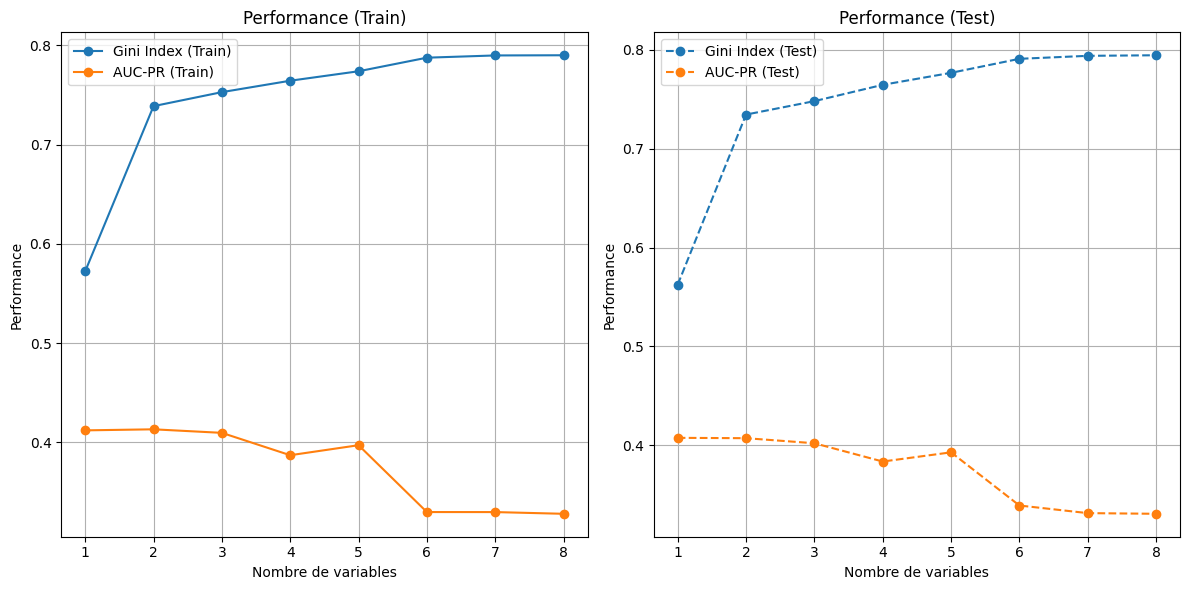

In [101]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Training performance
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.plot(results_df_train["Nb de variables"], results_df_train["Gini"], label="Gini Index (Train)", marker='o')
plt.plot(results_df_train["Nb de variables"], results_df_train["AUC-PR"], label="AUC-PR (Train)", marker='o')
plt.title("Performance (Train)")
plt.xlabel("Nombre de variables")
plt.ylabel("Performance")
plt.legend()
plt.grid()

# Testing performance
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.plot(results_df_test["Nb de variables"], results_df_test["Gini"], label="Gini Index (Test)", marker='o', linestyle='--')
plt.plot(results_df_test["Nb de variables"], results_df_test["AUC-PR"], label="AUC-PR (Test)", marker='o', linestyle='--')
plt.title("Performance (Test)")
plt.xlabel("Nombre de variables")
plt.ylabel("Performance")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


Selon le graphique ci-dessus et le tableau résumant les performances des modèles, le meilleur modèle à choisir est le modèle à trois variables.
En effet, il nous permet d'avoir le meilleur AUC-PR et un indice de gini de plus de 70%. De plus, tous ses coefficients sont significatifs et il n'y a pas de problème de multicolinéarité (VIF < 10). 

In [102]:
# Extraire les modèles du meilleur modèle
vars_selected = results_df_train["Variables"].iloc[2]
vars_selected

['CRTOC_IND_0015_dis', 'CRTOC_IND_0164_dis', 'CRTOC_AG_NBJCRE_2T_IND_0009_dis']

In [103]:
gini_index, auc_pr, flag_significativite, flag_VIF, flag_OR, model, modalites_reference =logit_reg(vars_selected, cible, y_train, X_train_reg)

In [104]:
model.params

const                                           -5.755521
CRTOC_IND_0015_dis_(2.0, 8.0]                    0.408200
CRTOC_IND_0015_dis_(24.0, inf]                   2.900332
CRTOC_IND_0015_dis_(8.0, 24.0]                   0.849997
CRTOC_IND_0164_dis_(-inf, 27800.0]               1.870761
CRTOC_IND_0164_dis_(27800.0, 160100.0]           0.929130
CRTOC_AG_NBJCRE_2T_IND_0009_dis_(-inf, 176.0]    0.645754
dtype: float64

In [105]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               396411
Model:                          Logit   Df Residuals:                   396404
Method:                           MLE   Df Model:                            6
Date:                Tue, 24 Dec 2024   Pseudo R-squ.:                  0.3169
Time:                        23:10:02   Log-Likelihood:                -26154.
converged:                       True   LL-Null:                       -38286.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -5.7555      0.035   -165.091      0.000      -5.824      -5.687
CRTOC_IND_0015_dis_(2.0, 8.0]                     0.4082      0.062      6.586      0.000       0.287       0.530
CRTOC_IND_0015_dis_(24.0, inf]                    2.9003      0.036     80.538      0.000       2.830       2.971
CRTOC_IND_0015_dis_(8.0, 24.0]                    0.8500      0.051     16.742      0.000       0.750       0.950
CRTOC_IND_0164_dis_(-inf, 27800.0]                1.8708      0.043     43.815      0.000       1.787       1.954
CRTOC_IND_0164_dis_(27800.0, 160100.0]            0.9291      0.049     18.826      0.000       0.832       1.026
CRTOC_AG_NBJCRE_2T_IND_0009_dis_(-inf, 176.0]     0.6458      0.034     19.058      0.000       0.579       0.712
=================================================================================================================
"""

In [106]:
coefficients = pd.Series(model.params)

for modalite in modalites_reference:
    if modalite not in coefficients.index:
        coefficients[modalite] = 0

coefficients

const                                           -5.755521
CRTOC_IND_0015_dis_(2.0, 8.0]                    0.408200
CRTOC_IND_0015_dis_(24.0, inf]                   2.900332
CRTOC_IND_0015_dis_(8.0, 24.0]                   0.849997
CRTOC_IND_0164_dis_(-inf, 27800.0]               1.870761
CRTOC_IND_0164_dis_(27800.0, 160100.0]           0.929130
CRTOC_AG_NBJCRE_2T_IND_0009_dis_(-inf, 176.0]    0.645754
CRTOC_IND_0015_dis_(-inf, 2.0]                   0.000000
CRTOC_IND_0164_dis_(160100.0, inf]               0.000000
CRTOC_AG_NBJCRE_2T_IND_0009_dis_(176.0, inf]     0.000000
dtype: float64

In [107]:
# Initialisation de SC
SC = {}

# Calcul des coefficients pour chaque variable
for var in vars_selected:
    var_coeffs = coefficients[coefficients.index.str.startswith(var)]
    min_coef = var_coeffs.min()
    var_coeffs = var_coeffs - min_coef
    alpha_j = var_coeffs.max()

    # Compute the denominator Σ_j max(c(j, i))
    denominator = sum(coefficients[coefficients.index.str.startswith(var)].max() for var in vars_selected)
    score_max = coefficients[coefficients.index.str.startswith(var)].max()

    # Calculate SC and CTR
    CTR = score_max / 10  # Calcul de CTR
    
    # Afficher les proportions pour toutes les modalités
    prop_count = X_train_reg[var].value_counts(normalize=True)
    tx_defaut = X_train_reg.groupby(var)[cible].mean()
    
    # Identifier la modalité la plus risquée (avec le taux de défaut maximal)
    max_risk_modality = tx_defaut.idxmax()  # Modalité avec le taux de défaut maximal
    max_risk_value = tx_defaut.max()       # Taux de défaut de la modalité la plus risquée

    # Calcul de SC_j (note moyenne pondérée pour la variable actuelle)
    SC_j = sum(
        prop_count.get(modality, 0) * (1000 * abs(coef - alpha_j) / denominator)
        for modality, coef in zip(var_coeffs.index.str[len(var) + 1:], var_coeffs.values)
    )
    
    # Calcul du numérateur pour q_j
    numerator = sum(
        prop_count.get(modality, 0) * ((1000 * abs(coef - alpha_j) / denominator) - SC_j) ** 2
        for modality, coef in zip(var_coeffs.index.str[len(var) + 1:], var_coeffs.values)
    ) ** 0.5


    for modality, coef in zip(var_coeffs.index.str[len(var) + 1:], var_coeffs.values):
        relative_gap = abs(tx_defaut.get(modality, 0) - max_risk_value) / max_risk_value if max_risk_value != 0 else 0

        SC[modality] = {
            "Variables" : var,
            "Modalities_merge" : var + "_" + modality,
            "coef" : coef,
            "SC(j, i)": 1000 * abs(coef - alpha_j) / denominator,
            "CTR": CTR  ,# Ajout de CTR,
            "p_j" : prop_count.get(modality, 0),
            "tx_defaut" : tx_defaut.get(modality, 0),
            "relative_gap": relative_gap,
            "m": prop_count.count(),
            "n": len(vars_selected),
        }

# Convertir les résultats en DataFrame pour une meilleure visualisation
SC_df = pd.DataFrame.from_dict(SC, orient="index").reset_index()
SC_df.columns = ["Variable_Modality", "Variables","Modalities_merge","coef", "SC(j, i)", "CTR","p_k","tx_defaut","relative_gap","m","n"]
SC_df = SC_df[["Variables", "Variable_Modality","Modalities_merge", "coef", "SC(j, i)", "CTR", "p_k", "tx_defaut", "relative_gap", "m", "n"]]

In [108]:
#S_j (note moyenne pondérée) pour chaque variable
SC_df['SC_j'] = SC_df.groupby('Variables')['SC(j, i)'].transform(lambda x: (x * SC_df.loc[x.index, 'p_k']).sum())

# Calcul de q_j pour chaque variable
q_j = {}
denominator=0
for var in vars_selected:
    # Sous-ensemble pour la variable
    var_data = SC_df[SC_df['Variables'] == var]
    
    # Numérateur : \(\sqrt{\sum_{k=1}^m p_k (SC(j, k) - SC_j)^2}\)
    numerator = np.sqrt(np.sum(var_data['p_k'] * (var_data['SC(j, i)'] - var_data['SC_j'])**2))
    denominator += numerator
    q_j[var] = numerator


# diviser le numérateur par le dénominateur
for var in q_j.keys():
    q_j[var] = q_j[var] / denominator


In [109]:
# Ajout des contributions q_j dans le DataFrame
SC_df['q_j'] = SC_df['Variables'].map(q_j)

SC_df.sort_values(by=["Variables", "coef"], inplace=True)
SC_df

,Variables,Variable_Modality,Modalities_merge,coef,"SC(j, i)",CTR,p_k,tx_defaut,relative_gap,m,n,SC_j,q_j
8,CRTOC_AG_NBJCRE_2T_IND_0009_dis,"(176.0, inf]","CRTOC_AG_NBJCRE_2T_IND_0009_dis_(176.0, inf]",0.000000,119.212140,0.064575,0.794534,0.007112,0.895440,2,3,94.718093,0.176697
7,CRTOC_AG_NBJCRE_2T_IND_0009_dis,"(-inf, 176.0]","CRTOC_AG_NBJCRE_2T_IND_0009_dis_(-inf, 176.0]",0.645754,0.000000,0.064575,0.205466,0.068018,0.000000,2,3,94.718093,0.176697
3,CRTOC_IND_0015_dis,"(-inf, 2.0]","CRTOC_IND_0015_dis_(-inf, 2.0]",0.000000,535.428121,0.290033,0.925746,0.008208,0.979179,4,3,516.488489,0.316795
0,CRTOC_IND_0015_dis,"(2.0, 8.0]","CRTOC_IND_0015_dis_(2.0, 8.0]",0.408200,460.070628,0.290033,0.025105,0.032657,0.917155,4,3,516.488489,0.316795
2,CRTOC_IND_0015_dis,"(8.0, 24.0]","CRTOC_IND_0015_dis_(8.0, 24.0]",0.849997,378.510735,0.290033,0.024485,0.060684,0.846054,4,3,516.488489,0.316795
1,CRTOC_IND_0015_dis,"(24.0, inf]","CRTOC_IND_0015_dis_(24.0, inf]",2.900332,0.000000,0.290033,0.024664,0.394190,0.000000,4,3,516.488489,0.316795
6,CRTOC_IND_0164_dis,"(160100.0, inf]","CRTOC_IND_0164_dis_(160100.0, inf]",0.000000,345.359739,0.187076,0.599983,0.003612,0.952946,3,3,241.942111,0.506508
5,CRTOC_IND_0164_dis,"(27800.0, 160100.0]","CRTOC_IND_0164_dis_(27800.0, 160100.0]",0.929130,173.833739,0.187076,0.199800,0.010467,0.863636,3,3,241.942111,0.506508
4,CRTOC_IND_0164_dis,"(-inf, 27800.0]","CRTOC_IND_0164_dis_(-inf, 27800.0]",1.870761,0.000000,0.187076,0.200216,0.076756,0.000000,3,3,241.942111,0.506508


In [110]:
from pprint import pprint
pprint(SC_df.set_index(["Modalities_merge"])["SC(j, i)"].to_dict())

{'CRTOC_AG_NBJCRE_2T_IND_0009_dis_(-inf, 176.0]': 0.0,
 'CRTOC_AG_NBJCRE_2T_IND_0009_dis_(176.0, inf]': 119.21213962642118,
 'CRTOC_IND_0015_dis_(-inf, 2.0]': 535.4281211972448,
 'CRTOC_IND_0015_dis_(2.0, 8.0]': 460.0706282748842,
 'CRTOC_IND_0015_dis_(24.0, inf]': 0.0,
 'CRTOC_IND_0015_dis_(8.0, 24.0]': 378.5107347929747,
 'CRTOC_IND_0164_dis_(-inf, 27800.0]': 0.0,
 'CRTOC_IND_0164_dis_(160100.0, inf]': 345.359739176334,
 'CRTOC_IND_0164_dis_(27800.0, 160100.0]': 173.8337394314354}


In [147]:
def calculate_individual_scores(df_sc, df_individuals):
    """
    Calcule les scores des modalités associées à chaque individu et ajoute 
    la somme des scores dans le DataFrame des individus.

    Args:
        df_sc (pd.DataFrame): Une DataFrame contenant les scores par modalité (`SC(j, i)`).
            Elle doit inclure les colonnes `Modalities_merge` (concaténation variable_modalité) et `SC(j, i)`.
        df_individuals (pd.DataFrame): Une DataFrame contenant les données des individus,
            où chaque colonne est une variable et chaque valeur est une modalité.

    Returns:
        pd.DataFrame: Le DataFrame des individus avec une colonne supplémentaire `Total_Score`.
    """
    # Créer un dictionnaire pour rechercher rapidement les scores des modalités
    modality_scores = df_sc.set_index("Modalities_merge")["SC(j, i)"].to_dict()

    # Calculer les scores totaux pour chaque individu
    total_scores = []
    for idx, row in tqdm(df_individuals.iterrows()):
        total_score = 0
        for variable, modality in row.items():
            # Construire la clé `variable_modalité`
            modality_merge = f"{variable}_{modality}"
            # Ajouter le score de la modalité correspondante si elle existe dans df_sc
            total_score += modality_scores.get(modality_merge, 0)
        total_scores.append(total_score)
    
    # Ajouter les scores totaux au DataFrame des individus
    df_individuals["score"] = total_scores
    
    return df_individuals



In [149]:
score = calculate_individual_scores(SC_df, X_train_reg[vars_selected+[cible]])

0it [00:00, ?it/s]

396411it [00:12, 30536.54it/s]
/tmp/ipykernel_7331/2542841282.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_individuals["score"] = total_scores


In [159]:
sample=pd.DataFrame()
sample["label"] = score[cible].replace({0: 'sain', 1: 'défaut'})
sample["score"] = score["score"]
sample.head()

,label,score
0,sain,1000.000000
1,sain,654.640261
2,sain,1000.000000
3,sain,1000.000000
4,sain,1000.000000


In [162]:
# On copie 'sample' et change tous les labels en 'total'
sample_total = sample.copy()
sample_total['label'] = 'total'

# On fusionne sample et sample_total
sample_full = pd.concat([sample, sample_total])

,label,score
0,sain,1000.000000
1,sain,654.640261
2,sain,1000.000000
3,sain,1000.000000
4,sain,1000.000000
...,...,...
396406,total,535.428121
396407,total,1000.000000
396408,total,828.474000
396409,total,535.428121


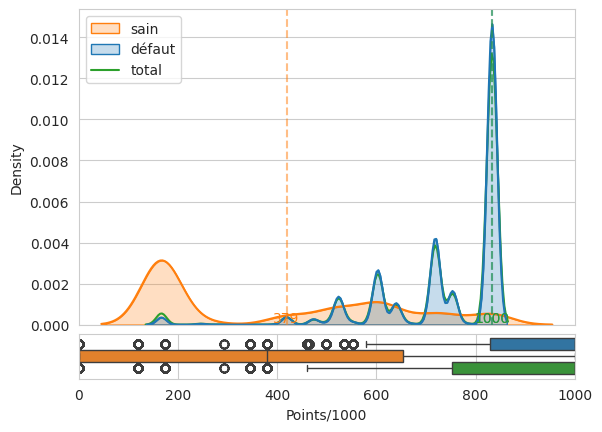

In [195]:
# Création des sous-graphiques
fig, ax = plt.subplot_mosaic(
    """A
    A
    A
    A
    A
    A
    B
    """)

# On plot une KDE de sample selon le label, avec le kde qui s'arrête à 1000
sns.kdeplot(
    data=sample, x='score', hue='label', common_norm=False, 
    fill=True, ax=ax['A']
)

# On plot en arrière-plan une KDE de sample_full
sns.kdeplot(
    data=sample_full, x='score', hue='label', common_norm=False, 
    ax=ax['A'], legend=False
)

# On rajoute 'total' à la légende
ax['A'].legend(labels=['sain', 'défaut', 'total'])

# On supprime les ticks des abscisses
ax['A'].set_xticks([])

# On plot un boxplot de sample selon le label
sns.boxplot(
    data=sample_full, x='score', hue='label', legend=False, ax=ax['B']
)
ax['B'].set(xlim=(0, 1000))

# On affiche les valeurs médianes par label sans qu'ils ne dépassent le pic du kde
for i, label in enumerate(sample['label'].unique()):
    median = sample[sample['label'] == label]['score'].median()
    ax['A'].axvline(x=median, color=f'C{i}', linestyle='--', alpha=0.5)
    ax['A'].text(median, 0, f"{median:.0f}", ha='center', va='bottom', color=f'C{i}')

# Idem pour le total
median = sample_full['score'].median()
ax['A'].axvline(x=median, color='C2', linestyle='--', alpha=0.5)
ax['A'].text(median, 0, f"{median:.0f}", ha='center', va='bottom', color='C2')

# Labels et style final
ax['B'].set(xlabel='Points/1000')
sns.set_style('whitegrid')

plt.show()
